Le malattie cardiovascolari rappresentano la principale causa di morte a livello globale, solo in italia si contano circa 200 mila decessi l'anno (dati Istat/Iss).
Tra i fattori determinanti delle malattie cardiovascolari troviamo il fumo, il colesterolo alto e la sedentarietà.

Si dimostra quindi essenziale velocizzare i processi diagnostici supportando i medici con strumenti tecnologici avanzati. I modelli di apprendimento automatico, tra cui le reti Deep Learning, sono sicuramente uno strumento valido per la diagnosi di malattie cardiovascolari. L'efficacia di tali modelli dipende dalla qualità dei dati utilizzati e dal numero di features/caratteristiche raccolte.


In [343]:
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split
# from sklearn.model_selection import train_test_split

In [344]:
device = (
    (torch.cuda.is_available() and "cuda")
    or (torch.backends.mps.is_available() and "mps")
    or "cpu"
)
torch.device(device)

device(type='mps')

In [345]:
# MANUAL SEED per partire sempre nelle stesse condizioni

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

match device:
    case "cuda":
        torch.cuda.manual_seed(SEED)
        torch.cuda.manual_seed_all(SEED)  # if you are using multi-GPU.
    case "mps":
        torch.mps.manual_seed(SEED)


torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [346]:
df = pd.read_csv("input/heart.csv")
df.head()

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')

In [347]:
df.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

In [348]:
bool_cols = df.select_dtypes(include=["bool"]).columns
df[bool_cols] = df[bool_cols].astype("int")

string_cols = df.select_dtypes(include="object").columns
df[string_cols] = df[string_cols].astype("string")
df.dtypes

Age                        int64
Sex               string[python]
ChestPainType     string[python]
RestingBP                  int64
Cholesterol                int64
FastingBS                  int64
RestingECG        string[python]
MaxHR                      int64
ExerciseAngina    string[python]
Oldpeak                  float64
ST_Slope          string[python]
HeartDisease               int64
dtype: object

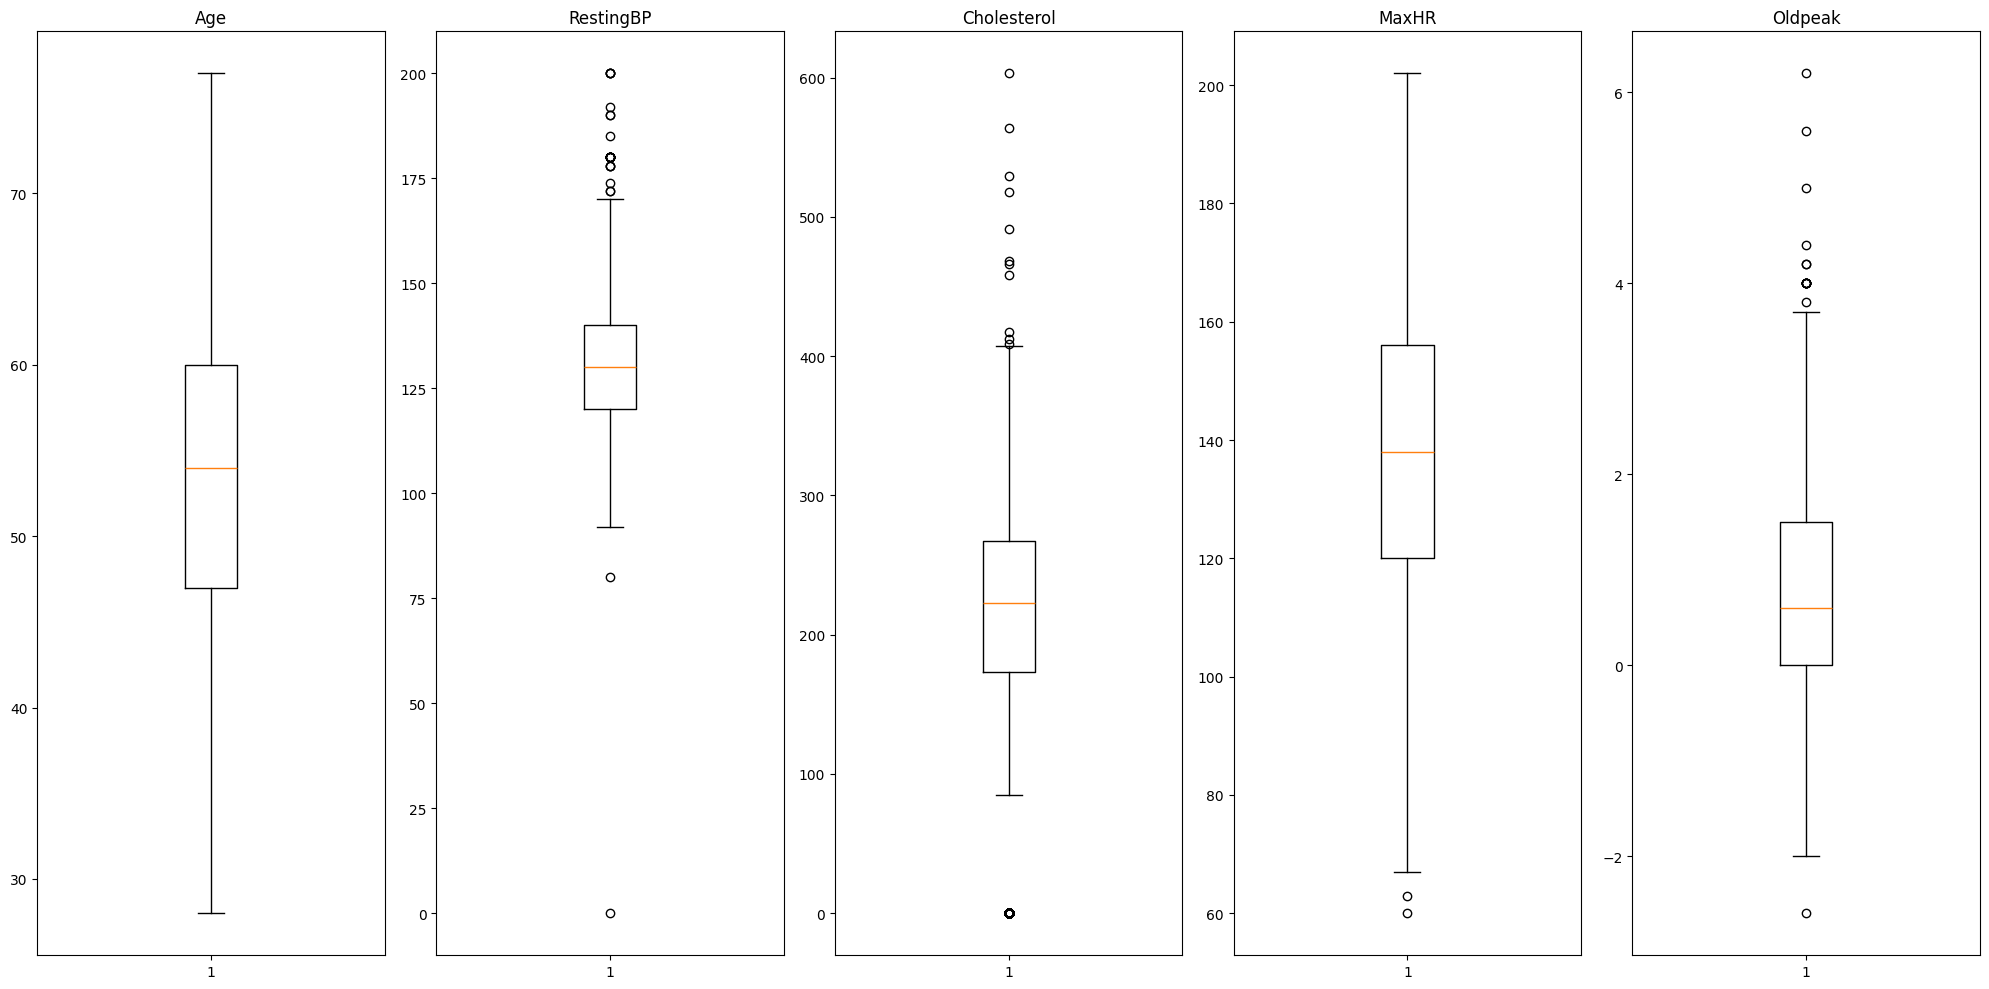

In [349]:
numerical_cols = df.select_dtypes(include=["int64", "float64"]).columns
numerical_cols = numerical_cols.drop(
    ["HeartDisease", "FastingBS"]
)  # rimuovo la colonna target e la colonna FastingBS

fig, axs = plt.subplots(nrows=1, ncols=len(numerical_cols), figsize=(20, 10))

for i, col in enumerate(numerical_cols):
    axs[i].boxplot(df[col])
    axs[i].set_title(col)

plt.tight_layout()
plt.show()

In [350]:
# Rimozione outliers
resting_bp_outliers = df[df["RestingBP"] < 20]  # è morto? Lo rimuovo?
df.drop(resting_bp_outliers.index, inplace=True)

df[df["Cholesterol"] == 0].value_counts().sum()  # colesterolo tropo basso
df.drop(df[df["Cholesterol"] == 0].index, inplace=True)
df.value_counts().sum()

746

In [351]:
# One-hot encoding
df = pd.get_dummies(df, columns=list(string_cols), drop_first=True, dtype=int)
# Dove:
# - drop_first=True rimuove la prima colonna (prima categoria della colonna) dummy per evitare la multi-collinearità
df.head()


# poi riposizionamo la colonna target come ultima
target_col = df["HeartDisease"]
df.drop("HeartDisease", axis=1, inplace=True)
df = pd.concat([df, target_col], axis=1)
df.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up,HeartDisease
0,40,140,289,0,172,0.0,1,1,0,0,1,0,0,0,1,0
1,49,160,180,0,156,1.0,0,0,1,0,1,0,0,1,0,1
2,37,130,283,0,98,0.0,1,1,0,0,0,1,0,0,1,0
3,48,138,214,0,108,1.5,0,0,0,0,1,0,1,1,0,1
4,54,150,195,0,122,0.0,1,0,1,0,1,0,0,0,1,0


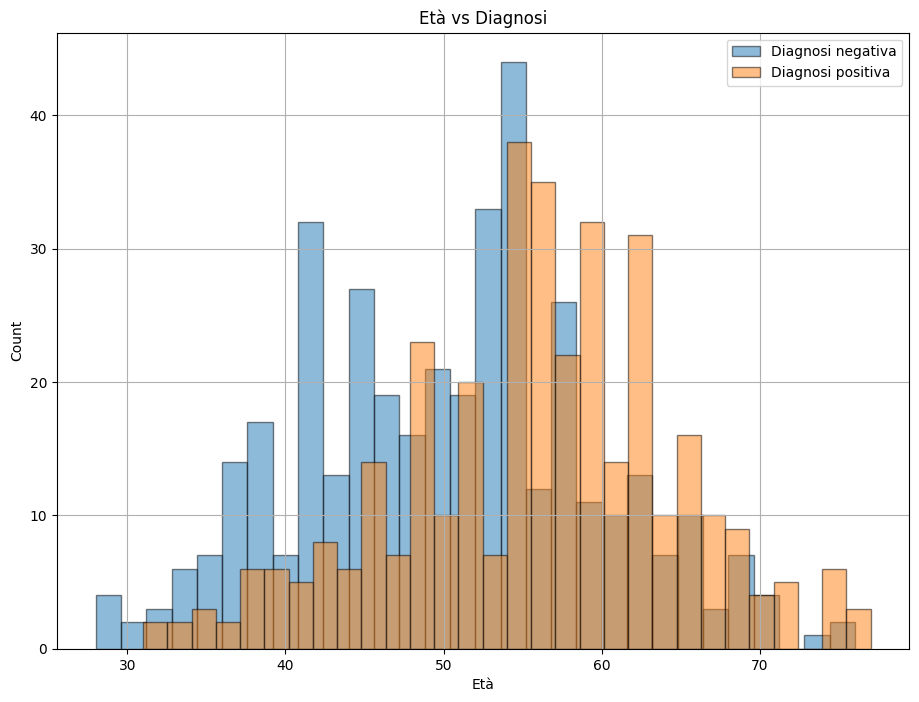

In [352]:
# Mostriamo relazione tra età e diagnosi
fig, ax = plt.subplots(figsize=(11, 8))


df[df["HeartDisease"] == 0]["Age"].hist(
    ax=ax, bins=30, edgecolor="black", alpha=0.5, label="Diagnosi negativa"
)
df[df["HeartDisease"] == 1]["Age"].hist(
    ax=ax, bins=30, edgecolor="black", alpha=0.5, label="Diagnosi positiva"
)


ax.set_title("Età vs Diagnosi")
ax.set_xlabel("Età")
ax.set_ylabel("Count")


ax.legend()


plt.show()

In [353]:
# funzioni calcolo dev standard e correlazione (per puro scopo dimostrativo)


def calc_std(values):
    n = len(values)
    m = sum(values) / n
    return np.sqrt(
        sum((c - m) ** 2 for c in values) / (n - 1)
    )  # n-1 perchè si tratta di un campione e non dell'intera popolazione


def calc_corr(v1, v2):
    n = len(v1)
    if n != len(v2):
        raise ValueError("Arrays must have the same length")
    m1 = sum(v1) / n
    m2 = sum(v2) / n
    s1 = calc_std(v1)
    s2 = calc_std(v2)
    return sum(((c1 - m1) * (c2 - m2) for (c1, c2) in zip(v1, v2))) / (
        (n - 1) * s1 * s2
    )

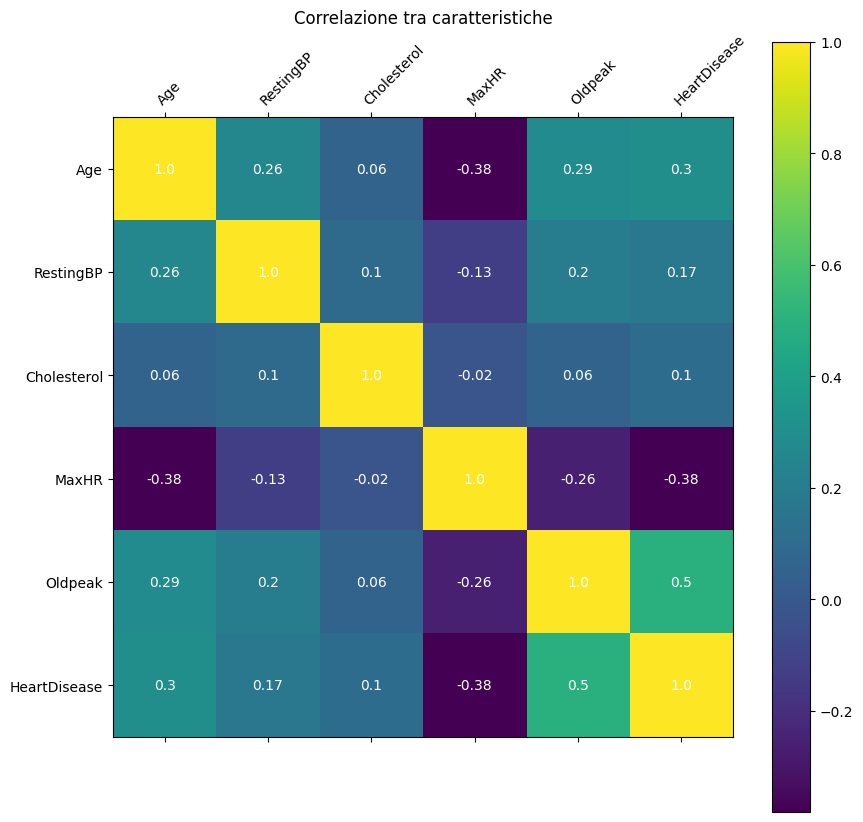

In [354]:
# Matrice di correlazione

cols = ["Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak", "HeartDisease"]

corr_mat = []
for row_key in cols:
    row = []
    for col_key in cols:
        # corr = calc_corr(df[row_key], df[col_key])
        # altamente inefficiente farlo in python, numpy invece usa c bindings
        corr = df[row_key].corr(df[col_key])
        row.append(corr)
    corr_mat.append(row)


fig, ax = plt.subplots(figsize=(10, 10))
cax = ax.matshow(corr_mat)
fig.colorbar(cax, ax=ax)


ax.set_xticks(np.arange(len(cols)))
ax.set_yticks(np.arange(len(cols)))

ax.set_xticklabels(cols)
ax.set_yticklabels(cols)

plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")

for i in range(len(corr_mat)):
    for j in range(len(corr_mat[i])):
        ax.text(j, i, round(corr_mat[i][j], 2), ha="center", va="center", color="w")

ax.set_title("Correlazione tra caratteristiche")

plt.show()

In [355]:
clean_df = df.copy()
# clean_df.drop("id", axis=1, inplace=True) # dove con axis 1 indica le colonne
scaler = StandardScaler()
input_data = torch.from_numpy(
    scaler.fit_transform(clean_df.drop("HeartDisease", axis=1).to_numpy())
).float()
target_data = torch.from_numpy(clean_df["HeartDisease"].to_numpy()).float().unsqueeze(1)

dataset = TensorDataset(input_data, target_data)
train_data_len = int(len(dataset) * 0.8)
test_data_len = int(len(dataset) - train_data_len)
train_dataset, test_dataset = random_split(dataset, [train_data_len, test_data_len])

batch_size = 32

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [356]:
class LogisticRegressionNet(nn.Module):
    def __init__(self, input_size=input_data.shape[1]):
        super(LogisticRegressionNet, self).__init__()
        self.fc = nn.Linear(input_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc(x)
        x = self.sigmoid(x)
        return x


class MLPNet(nn.Module):
    def __init__(self, input_size=input_data.shape[1], hidden_size=64):
        super(MLPNet, self).__init__()
        self.relu_stack = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1),
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu_stack(x)
        x = self.sigmoid(x)
        return x


# Hyper-params
lr = 1e-3
epochs = 100


net = MLPNet()
net.to(device)

loss_fn = nn.BCELoss()  # Binary Cross Entropy
# Dove:
# - BCELoss: usato per classificazione binaria e NON include layer sigmoid
# - BCEWithLogitsLoss: usato per classificazione binaria e include layer sigmoid
# nel nostro caso, abbiamo incluso il layer sigmoid nel modello, quindi usiamo BCELoss

# Optimizer
optmzr = optim.Adam(net.parameters(), lr=lr)
# Dove:
# - SGD: utilizza una sola riga del batch per calcolare il gradiente e aggiornare i pesi
# - Adam: genera una desc. statistica (e.g. media, std) dei gradienti calcolati per più righe del batch e ottimizza il learning rate di conseguenza

In [357]:
def train_loop(
    dataloader,
    model: nn.Module,
    loss_fn,
    optimizer: optim.Optimizer,
    step=10,
):
    model.train()
    size = len(dataloader.dataset)

    for batch_idx, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)

        pred = model(X)

        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (
            (batch_idx == 0)
            or ((batch_idx + 1) % step == 0)
            or ((batch_idx + 1) == len(dataloader))
        ):
            loss, current = loss.item(), (batch_idx * batch_size) + len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")


def test_loop(
    dataloader,
    model: nn.Module,
    loss_fn,
):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += pred.round().eq(y).sum().item()
    test_loss /= num_batches
    correct /= size
    print(
        f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n"
    )

In [358]:
for epoch_idx in range(epochs):
    print(f"Epoch {epoch_idx+1}\n-------------------------------")
    train_loop(train_dataloader, net, loss_fn, optmzr)
    test_loop(test_dataloader, net, loss_fn)
print("Done")

Epoch 1
-------------------------------
loss: 0.684326 [   32/  596]
loss: 0.622120 [  320/  596]
loss: 0.544171 [  596/  596]
Test Error: 
 Accuracy: 84.0%, Avg loss: 0.552953 

Epoch 2
-------------------------------
loss: 0.525518 [   32/  596]
loss: 0.480646 [  320/  596]
loss: 0.444329 [  596/  596]
Test Error: 
 Accuracy: 84.0%, Avg loss: 0.400224 

Epoch 3
-------------------------------
loss: 0.432012 [   32/  596]
loss: 0.510750 [  320/  596]
loss: 0.399671 [  596/  596]
Test Error: 
 Accuracy: 84.7%, Avg loss: 0.339694 

Epoch 4
-------------------------------
loss: 0.303625 [   32/  596]
loss: 0.512035 [  320/  596]
loss: 0.775666 [  596/  596]
Test Error: 
 Accuracy: 85.3%, Avg loss: 0.333099 

Epoch 5
-------------------------------
loss: 0.386576 [   32/  596]
loss: 0.388094 [  320/  596]
loss: 0.168259 [  596/  596]
Test Error: 
 Accuracy: 85.3%, Avg loss: 0.335274 

Epoch 6
-------------------------------
loss: 0.281641 [   32/  596]
loss: 0.362328 [  320/  596]
loss: 0

In [359]:
# with torch.no_grad():
#     cardio = clean_df.iloc[1].cardio
#     input = (
#         torch.from_numpy(clean_df.iloc[1].drop("cardio").to_numpy()).float().to(device)
#     )
#     pred = net(input)
#     print(cardio, pred)